<a href="https://colab.research.google.com/github/chanmyae99/resume-bert-classification/blob/main/notebooks/03_bert_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Model Training for Resume Classification

This notebook implements end-to-end BERT-based resume classification using the
preprocessed dataset. Tokenization and model training are performed within a
single notebook to maintain a clear and reproducible pipeline.

Tokenization parameters are fixed based on prior analysis and applied
consistently throughout model training and evaluation.


## Import Required Libraries


In [1]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


## Load Preprocessed Dataset

The preprocessed dataset is loaded from disk. The dataset contains cleaned resume
text and corresponding category labels.


In [2]:
!git clone https://github.com/chanmyae99/resume-bert-classification.git

Cloning into 'resume-bert-classification'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 140 (delta 53), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 1.98 MiB | 4.23 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [3]:
%cd resume-bert-classification/notebooks

/content/resume-bert-classification/notebooks


In [4]:
df = pd.read_csv("../data/preprocessed/CHAN_MYAE_AUNG_preprocessed.csv")
df.head()


,Category,Resume
0,Python Developer,technical skills languages python framework dj...
1,Health and fitness,education details january 2018 m s nutrition a...
2,Data Science,education details mca ymcaust faridabad haryan...
3,Network Security Engineer,operating systems windows linux ubuntu network...
4,Java Developer,education details be it pjlce java developer j...


In [5]:
df.duplicated().sum()

np.int64(0)

## Encode Target Labels

Resume categories are encoded into numerical labels to enable model training.


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])

df[["Category", "label"]].head()


,Category,label
0,Python Developer,20
1,Health and fitness,14
2,Data Science,6
3,Network Security Engineer,17
4,Java Developer,15


## Train–Validation Split

The dataset is split into training and validation sets to evaluate model
generalisation performance.


In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Resume"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


## BERT Tokenization for Resume Classification

This notebook performs tokenization of preprocessed resume text using the BERT
tokenizer. Tokenization converts textual data into numerical representations that
can be processed by the BERT model for downstream classification.


### Purpose of Tokenization

BERT does not process raw text directly. Instead, text must be transformed into
a fixed-length sequence of tokens and corresponding numerical IDs.

The purpose of tokenization is to:
- Split resume text into WordPiece subword tokens
- Convert tokens into numerical input IDs
- Generate attention masks for padded tokens
- Enforce a fixed input length required by BERT


### Choice of Tokenizer

The `bert-base-uncased` tokenizer is used in this project to ensure compatibility
with the pretrained BERT Base model.

This tokenizer:
- Converts all text to lowercase
- Applies WordPiece tokenization
- Uses the same vocabulary and token mappings as the pretrained model


### Maximum Token Length Constraint in BERT

BERT has a fixed maximum input length of 512 tokens. This limitation is imposed
by the model’s positional embedding architecture, which is defined during
pretraining.

The original BERT model was pretrained using a maximum sequence length of
512 tokens, and therefore cannot process longer input sequences without
truncation.

**Source of evidence:**
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of
  Deep Bidirectional Transformers for Language Understanding*. NAACL-HLT.
- Hugging Face Transformers documentation: BERT configuration parameter
  `max_position_embeddings = 512`


In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### WordPiece Tokenization

BERT uses WordPiece tokenization, which breaks words into subword units based on
a fixed vocabulary. This enables the model to handle rare or unseen words
effectively.

For example:
- "microservices" → ["micro", "##services"]
- "university" → ["university"]


In [9]:
# Select a real resume from the dataset
sample_text = df["Resume"].iloc[0]

words = list(set(sample_text.split()))

# Limit to a small number for clarity
sample_words = words[20:30]

for word in sample_words:
    tokens = tokenizer.tokenize(word)
    print(f"{word} -> {tokens}")


details -> ['details']
arsys -> ['ars', '##ys']
may -> ['may']
2 -> ['2']
page -> ['page']
interface -> ['interface']
restfull -> ['rest', '##ful', '##l']
telecommunications -> ['telecommunications']
sqlite -> ['sql', '##ite']
track -> ['track']


### Token Length Analysis for Maximum Length Selection

Before selecting a maximum token length, it is necessary to analyse the number
of tokens produced by the BERT tokenizer for each resume. This ensures that the
chosen `max_length` is data-driven and minimises unnecessary truncation while
maintaining computational efficiency.


In [10]:
# Compute token length for each resume
token_lengths = df["Resume"].apply(
    lambda x: len(tokenizer.tokenize(x))
)

token_lengths.describe()


Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors


,Resume
count,218.000000
mean,461.288991
std,390.286594
min,19.000000
25%,184.250000
50%,344.500000
75%,616.000000
max,2316.000000


In [11]:
# Inspect extreme cases
print("Shortest resume token length:", token_lengths.min())
print("Longest resume token length:", token_lengths.max())
print("95th percentile token length:", token_lengths.quantile(0.95))


Shortest resume token length: 19
Longest resume token length: 2316
95th percentile token length: 1240.3999999999996


### Justification of Selected Maximum Token Length

Token length analysis indicates that resume documents are substantially longer
than typical short-text classification inputs. The median token length is
approximately 370 tokens, while the mean exceeds 500 tokens.

Given this distribution and the architectural constraint of BERT, a maximum
token length of 512 tokens was selected to preserve the majority of resume
content and minimise information loss due to truncation.



In [12]:
MAX_LENGTH = 512


In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors="pt"
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors="pt"
)



### Tokenization Outputs

The tokenizer generates the following tensors:

- `input_ids`: Numerical token identifiers representing WordPiece tokens
- `attention_mask`: Binary mask indicating which tokens are valid (1) and padded (0)

These tensors form the input to the BERT classification model.


In [14]:
print("input_ids shape:", train_encodings["input_ids"].shape)
print("attention_mask shape:", train_encodings["attention_mask"].shape)


input_ids shape: torch.Size([174, 512])
attention_mask shape: torch.Size([174, 512])


### Special Tokens Confirmation

Each tokenized sequence includes:
- `[CLS]` token at the beginning (used for classification)
- `[SEP]` token marking the end of the sequence
- `[PAD]` tokens for padding shorter sequences

This structure follows the standard input format required by BERT Base.


In [15]:
# Inspect tokens for a sample resume
sample_ids = train_encodings["input_ids"][0]
sample_tokens = tokenizer.convert_ids_to_tokens(sample_ids)

sample_tokens[:30]


['[CLS]',
 'computer',
 'skills',
 'holder',
 'of',
 'valid',
 'ks',
 '##a',
 'license',
 'basic',
 'computer',
 'ms',
 'office',
 'auto',
 '##ca',
 '##d',
 '2006',
 '##ed',
 '##uca',
 '##tion',
 'details',
 'january',
 '2005',
 'diploma',
 'bengal',
 '##uru',
 'karnataka',
 'oxford',
 'polytechnic',
 'bang']

## Dataset and DataLoader Preparation

Tokenized inputs and labels are wrapped into PyTorch datasets and loaded using
DataLoader for efficient batch processing.


In [16]:
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(train_labels)
)

val_dataset = TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    torch.tensor(val_labels)
)

train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

val_loader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)


## BERT Model Training

A pretrained BERT Base model is loaded and adapted for multi-class resume
classification.


### Bert Base Model Initialization

In [17]:
num_labels = df["label"].nunique()

base_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Optimizer Configuration

The AdamW optimizer is used, which is recommended for fine-tuning transformer
models.


In [18]:
import torch.optim as optim
base_optimizer = optim.AdamW(base_model.parameters(), lr=2e-5)


#### Model Training

The model is trained for a fixed number of epochs. Validation accuracy is
computed after each epoch.


In [19]:
def train_model(model, optimizer, num_epochs, train_losses,val_losses, train_accuracies, val_accuracies):

  epochs = num_epochs

  for epoch in range(epochs):
    # -------- TRAINING --------
    model.train()
    total_loss = 0
    train_preds, train_true = [], []

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        train_true.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = accuracy_score(train_true, train_preds)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}, Training accuracy: {train_acc:.4f}")

    # -------- VALIDATION --------
    model.eval()
    val_preds, val_true = [], []
    val_loss_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss_total += outputs.loss.item()
            logits = outputs.logits

            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_acc)

    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_acc:.4f}")


base_train_losses = []
base_val_losses = []
base_train_accuracies = []
base_val_accuracies = []
train_model(base_model, base_optimizer, num_epochs=10, train_losses=base_train_losses, val_losses=base_val_losses, train_accuracies=base_train_accuracies, val_accuracies=base_val_accuracies)

Epoch 1/10 - Training loss: 3.2758, Training accuracy: 0.0287
Validation loss: 3.2028, Validation accuracy: 0.0227
Epoch 2/10 - Training loss: 3.2036, Training accuracy: 0.0575
Validation loss: 3.1549, Validation accuracy: 0.0909
Epoch 3/10 - Training loss: 3.1572, Training accuracy: 0.0920
Validation loss: 3.0864, Validation accuracy: 0.0909
Epoch 4/10 - Training loss: 2.9982, Training accuracy: 0.1322
Validation loss: 2.8282, Validation accuracy: 0.2500
Epoch 5/10 - Training loss: 2.7458, Training accuracy: 0.2816
Validation loss: 2.5836, Validation accuracy: 0.3182
Epoch 6/10 - Training loss: 2.4019, Training accuracy: 0.4195
Validation loss: 2.2540, Validation accuracy: 0.3864
Epoch 7/10 - Training loss: 2.0279, Training accuracy: 0.5690
Validation loss: 1.9110, Validation accuracy: 0.6591
Epoch 8/10 - Training loss: 1.7365, Training accuracy: 0.7931
Validation loss: 1.6475, Validation accuracy: 0.7500
Epoch 9/10 - Training loss: 1.4180, Training accuracy: 0.8908
Validation loss: 1

#### Base Model Evaluation

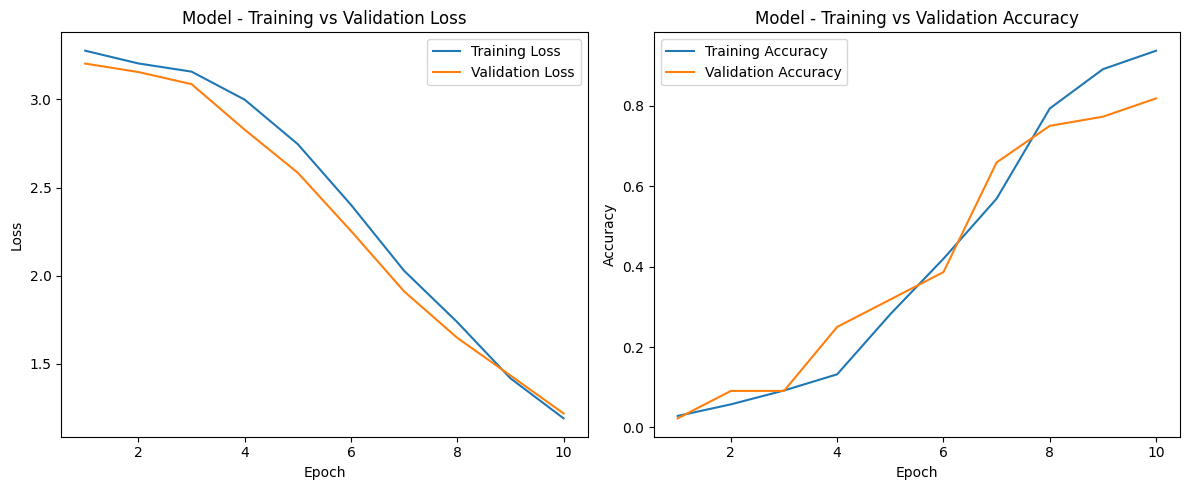

In [20]:
import matplotlib.pyplot as plt

def plot_training_curves(
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    title_prefix="Model"
):
    epochs = range(1, len(val_losses) + 1)

    plt.figure(figsize=(12, 5))

    # ---- Loss plot ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Training vs Validation Loss")
    plt.legend()

    # ---- Accuracy plot ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(base_train_losses, base_val_losses, base_train_accuracies, base_val_accuracies)

## Optimized Model Initialization and Training

### Optimized the model with 50 epochs and early stopping

In [31]:
opt_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
).to(device)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


#### Optimized Model Optimizer Configuration

We will configure the AdamW optimizer with weight decay as specified.

In [32]:
import torch.optim as optim
opt_optimizer = optim.AdamW(opt_model.parameters(), lr=2e-5)

#### Build the function to train the model with early-stopping

In [33]:
def train_model_early_stopping(model, optimizer, num_epochs):
  # These lists will be accumulated within this function and then returned
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  epochs = 60

  # Initialize early stopping parameters
  best_val_loss = float('inf')
  epochs_no_improve = 0
  patience = 3  # Number of epochs to wait for improvement
  min_delta = 0.001 # Minimum change to qualify as an improvement

  for epoch in range(epochs):
      # -------- TRAINING --------
      model.train()
      total_loss = 0
      train_preds, train_true = [], []

      for batch in train_loader:
          input_ids, attention_mask, labels = [x.to(device) for x in batch]

          optimizer.zero_grad()

          outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              labels=labels
          )

          loss = outputs.loss
          logits = outputs.logits

          total_loss += loss.item()

          train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
          train_true.extend(labels.cpu().numpy())

          loss.backward()
          optimizer.step()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      train_acc = accuracy_score(train_true, train_preds)
      train_accuracies.append(train_acc)

      print(
          f"Epoch {epoch+1}/{epochs} - "
          f"Training loss: {avg_train_loss:.4f}, "
          f"Training accuracy: {train_acc:.4f}"
      )

      # -------- VALIDATION --------
      model.eval()
      val_preds, val_true = [], []
      val_loss_total = 0

      with torch.no_grad():
          for batch in val_loader:
              input_ids, attention_mask, labels = [x.to(device) for x in batch]

              outputs = model(
                  input_ids=input_ids,
                  attention_mask=attention_mask,
                  labels=labels
              )

              val_loss_total += outputs.loss.item()
              logits = outputs.logits

              val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
              val_true.extend(labels.cpu().numpy())

      avg_val_loss = val_loss_total / len(val_loader)
      val_losses.append(avg_val_loss)

      val_acc = accuracy_score(val_true, val_preds)
      val_accuracies.append(val_acc)

      print(
          f"Validation loss: {avg_val_loss:.4f}, "
          f"Validation accuracy: {val_acc:.4f}"
      )

      # -------- EARLY STOPPING CHECK --------
      if (best_val_loss - avg_val_loss) > min_delta:
          best_val_loss = avg_val_loss
          epochs_no_improve = 0
          best_model_state = model.state_dict()
          print("✓ Validation loss improved — saving model")
      else:
          epochs_no_improve += 1
          print(f"No improvement for {epochs_no_improve} epoch(s)")

      if epochs_no_improve >= patience:
          print("Early stopping triggered")
          break

  return train_losses, val_losses, train_accuracies, val_accuracies

#### Optimized Model Training

Now, let's train the model with the new optimizer configuration and early stopping. We'll track the loss and accuracy during training and validation.

In [34]:
opt_train_losses = []
opt_val_losses = []
opt_train_accuracies = []
opt_val_accuracies = []
opt_train_losses, opt_val_losses, opt_train_accuracies, opt_val_accuracies = train_model_early_stopping(opt_model, opt_optimizer, num_epochs=50)

Epoch 1/60 - Training loss: 3.1898, Training accuracy: 0.0460
Validation loss: 3.1905, Validation accuracy: 0.0455
✓ Validation loss improved — saving model
Epoch 2/60 - Training loss: 3.1030, Training accuracy: 0.1149
Validation loss: 3.0224, Validation accuracy: 0.1591
✓ Validation loss improved — saving model
Epoch 3/60 - Training loss: 2.8896, Training accuracy: 0.2126
Validation loss: 2.8762, Validation accuracy: 0.1591
✓ Validation loss improved — saving model
Epoch 4/60 - Training loss: 2.6663, Training accuracy: 0.3391
Validation loss: 2.5157, Validation accuracy: 0.4091
✓ Validation loss improved — saving model
Epoch 5/60 - Training loss: 2.2954, Training accuracy: 0.6092
Validation loss: 2.2045, Validation accuracy: 0.5682
✓ Validation loss improved — saving model
Epoch 6/60 - Training loss: 2.0018, Training accuracy: 0.7701
Validation loss: 1.9173, Validation accuracy: 0.6818
✓ Validation loss improved — saving model
Epoch 7/60 - Training loss: 1.6983, Training accuracy: 0.8

#### Optimized Model Evaluation

Let's visualize the training and validation curves for the optimized model and see the final classification report.

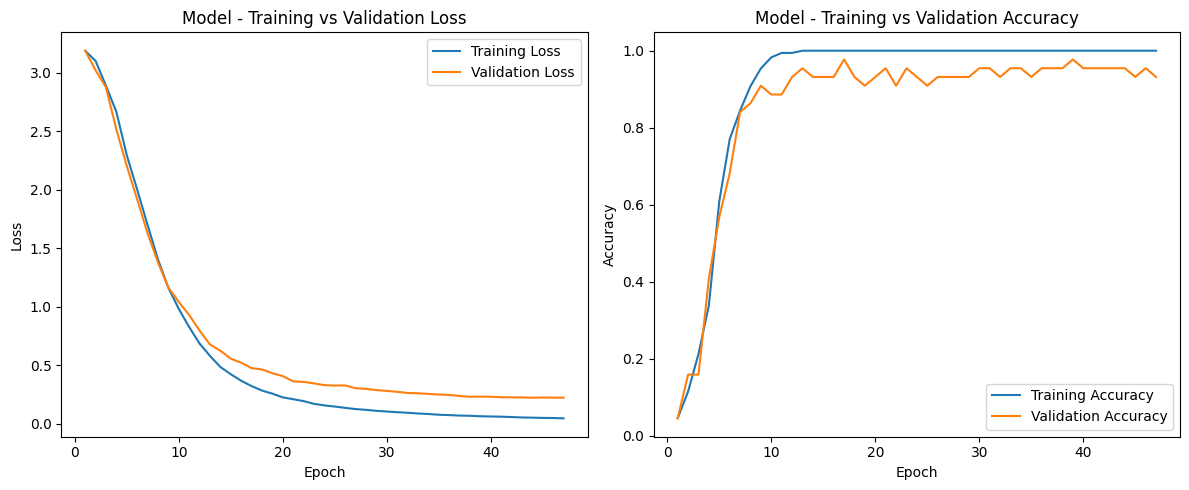

In [35]:
plot_training_curves(opt_train_losses, opt_val_losses, opt_train_accuracies, opt_val_accuracies)

In [36]:
import numpy as np

best_val_accuracy = np.max(opt_val_accuracies)
best_epoch = np.argmax(opt_val_accuracies) + 1  # +1 because epochs are 1-indexed

print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Achieved at Epoch: {best_epoch}")

Best Validation Accuracy: 0.9773
Achieved at Epoch: 17


This calculation uses `numpy` to efficiently find the maximum accuracy and its index in the `opt_val_accuracies` list. Since epoch numbers are typically 1-indexed, I add 1 to the array index to get the correct epoch number.

#### Optimized the AdamW

In [26]:
opt_model_2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
).to(device)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


#### Change the learning rate and parameters

In [27]:
import torch.optim as optim
# Configure AdamW optimizer
parameters = list(opt_model_2.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
parameters = [
{'params': [p for n, p in parameters if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in parameters if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer_2 = optim.AdamW(parameters, lr=2e-5)

#### Train the model

## Summary

This notebook implemented an end-to-end BERT-based resume classification
pipeline, including tokenization, model training, and evaluation. Tokenization
parameters were fixed based on prior analysis, and the pretrained BERT Base model
was fine-tuned on the resume dataset.
